In [95]:
from sklearn.datasets import load_diabetes
ds = load_diabetes(as_frame=True)
X = ds.data        # 10 features
y = ds.target      # target continuo
df = ds.frame      # X + y
X.shape, y.shape

((442, 10), (442,))

In [96]:
n_filas, n_cols = X.shape
print("Resumen del dataset Diabetes (scikit-learn)")
print(f"- X.shape = {X.shape}  → {n_filas} filas (pacientes) × {n_cols} columnas (características)")
print(f"- y.shape = {y.shape}  → {len(y)} valores objetivo (target), uno por cada fila de X")

print("\nColumnas (features):")
print(", ".join(X.columns))
print("target = progresión de la diabetes a 1 año (valor numérico continuo)")


Resumen del dataset Diabetes (scikit-learn)
- X.shape = (442, 10)  → 442 filas (pacientes) × 10 columnas (características)
- y.shape = (442,)  → 442 valores objetivo (target), uno por cada fila de X

Columnas (features):
age, sex, bmi, bp, s1, s2, s3, s4, s5, s6
target = progresión de la diabetes a 1 año (valor numérico continuo)


In [97]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

RANDOM_STATE = 42

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE
)

def evaluar(y_true, y_pred, etiqueta="", extra=None):
    import numpy as np
    from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

    n   = len(y_true)
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2  = r2_score(y_true, y_pred)

    texto = (f"[{etiqueta}] N={n} \n "
             f"MAE, en promedio el modelo se equivoca: {mae:.3f} del target \n "
             f"RMSE (cuanto se equivoca el modelo): {rmse:.3f} \n R²(correlación entre lo real y lo predicho): {r2:.3f}")
    if extra:
        texto += " | " + extra
    print(texto)
    return {"N": n, "MAE": mae, "RMSE": rmse, "R2": r2}


In [98]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

def parity_plot_con_interpretacion(y_true, y_pred, titulo=""):
    mae  = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2   = r2_score(y_true, y_pred)
    bias = (y_pred - y_true).mean()
    r    = np.corrcoef(y_true, y_pred)[0,1]
    resid = y_true - y_pred
    corr_absres_true = np.corrcoef(np.abs(resid), y_true)[0,1]
    q20, q80 = np.quantile(y_true, [0.2, 0.8])
    err_bajos = (y_true[y_true<=q20] - y_pred[y_true<=q20]).mean()
    err_altos = (y_true[y_true>=q80] - y_pred[y_true>=q80]).mean()

    plt.figure(figsize=(6,6))
    plt.scatter(y_true, y_pred, alpha=0.7)
    lims = [min(y_true.min(), y_pred.min()), max(y_true.max(), y_pred.max())]
    plt.plot(lims, lims)  # y = x (referencia)
    plt.xlim(lims); plt.ylim(lims)
    plt.xlabel("Real"); plt.ylabel("Predicho"); plt.title(titulo)
    txt = f"MAE={mae:.1f}\nRMSE={rmse:.1f}\nR²={r2:.3f}\nr={r:.3f}"
    plt.gca().text(0.02, 0.98, txt, transform=plt.gca().transAxes,
                   va="top", ha="left", bbox=dict(facecolor="white", alpha=0.8, edgecolor="none"))
    plt.tight_layout(); plt.show()

    print("— Interpretación —")
    print(f"• Ajuste global: R²={r2:.3f}, correlación r={r:.3f}. Menor dispersión alrededor de la diagonal ⇒ mejor.")
    if bias > 0:   print(f"• Sesgo medio: tendencia a SOBREestimar (+{bias:.1f}).")
    elif bias < 0: print(f"• Sesgo medio: tendencia a SUBestimar ({bias:.1f}).")
    else:          print("• Sesgo medio: prácticamente nulo.")
    print(f"• Errores en extremos: bajos(≤p20)={err_bajos:.1f}; altos(≥p80)={err_altos:.1f}.")
    if err_bajos < 0 and err_altos > 0:
        print("  (Patrón típico de regresión a la media: subestima altos y sobreestima bajos.)")
    if abs(corr_absres_true) >= 0.30:
        trend = "aumentan" if corr_absres_true>0 else "disminuyen"
        print(f"• Los errores absolutos {trend} con el valor real (corr={corr_absres_true:.2f}). Posible heterocedasticidad.")
    print(f"• MAE={mae:.1f} y RMSE={rmse:.1f} están en unidades del target (puntos). RMSE>MAE ⇒ hay errores grandes.\n")

def grafico_residuos_simple(y_real, y_pred, titulo="Residuos (Real - Predicho)"):
    residuos = y_real - y_pred

    plt.figure(figsize=(6,4))
    plt.scatter(y_real, residuos, alpha=0.7)
    plt.axhline(0, ls="--")
    plt.xlabel("Valor real"); plt.ylabel("Residuo (Real - Predicho)")
    plt.title(titulo)
    plt.tight_layout(); plt.show()

    print("🔎 Interpretación sencilla")
    print("• Queremos una nube alrededor de 0, sin forma rara.")
    print("• Si hay curva/tendencia, el modelo comete un error sistemático.")
    print("• Si la nube se abre como embudo, el error cambia con el valor (heterocedasticidad).")
    print(f"• Residuo medio: {residuos.mean():+.1f} (positivo=predice bajo; negativo=predice alto).")


[LinearRegression] N=89 
 MAE, en promedio el modelo se equivoca: 42.794 del target 
 RMSE (cuanto se equivoca el modelo): 53.853 
 R²(correlación entre lo real y lo predicho): 0.453


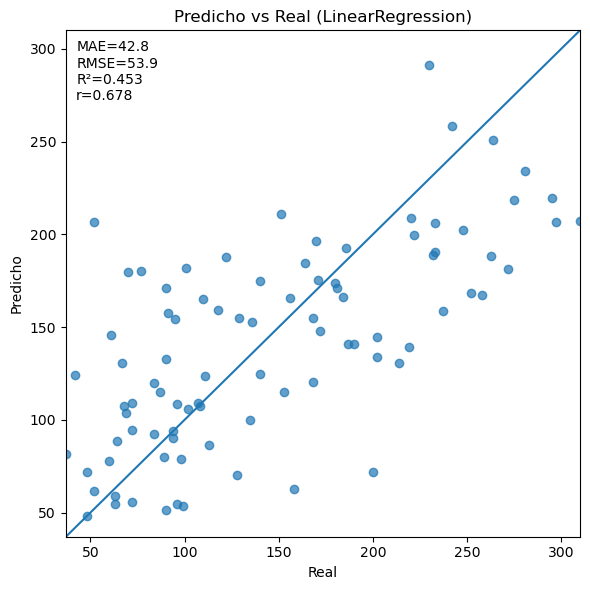

— Interpretación —
• Ajuste global: R²=0.453, correlación r=0.678. Menor dispersión alrededor de la diagonal ⇒ mejor.
• Sesgo medio: tendencia a SUBestimar (-3.9).
• Errores en extremos: bajos(≤p20)=-40.0; altos(≥p80)=50.3.
  (Patrón típico de regresión a la media: subestima altos y sobreestima bajos.)
• MAE=42.8 y RMSE=53.9 están en unidades del target (puntos). RMSE>MAE ⇒ hay errores grandes.



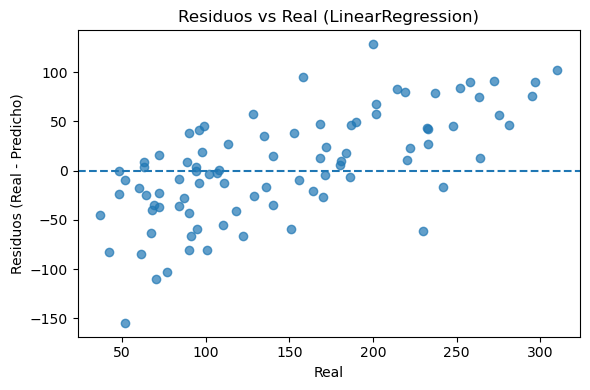

— Interpretación —
• Centrados en 0 y sin patrón ⇒ bien. Curva/U ⇒ sesgo. Dispersión creciente ⇒ heterocedasticidad.
• Media de residuos: 3.91 | Desviación: 54.02



In [99]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression

linreg = Pipeline([
    ("scaler", StandardScaler()),
    ("model", LinearRegression())
])

linreg.fit(X_train, y_train)
y_pred_lr = linreg.predict(X_test)
res_lr = evaluar(y_test, y_pred_lr, etiqueta="LinearRegression")

parity_plot_con_interpretacion(y_test, y_pred_lr, "Predicho vs Real (LinearRegression)")
residuos_con_interpretacion(y_test, y_pred_lr, "Residuos vs Real (LinearRegression)")

In [100]:
cv = KFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
scores_lr = cross_val_score(linreg, X, y, cv=cv, scoring="r2", n_jobs=-1)
scores_rf = cross_val_score(rf, X, y, cv=cv, scoring="r2", n_jobs=-1)

print(f"CV R² LinearRegression: media={scores_lr.mean():.3f} ± {scores_lr.std():.3f}")
print(f"CV R² RandomForest    : media={scores_rf.mean():.3f} ± {scores_rf.std():.3f}")

CV R² LinearRegression: media=0.478 ± 0.085
CV R² RandomForest    : media=0.427 ± 0.095


[RandomForestRegressor] N=89 
 MAE, en promedio el modelo se equivoca: 44.578 del target 
 RMSE (cuanto se equivoca el modelo): 54.757 
 R²(correlación entre lo real y lo predicho): 0.434


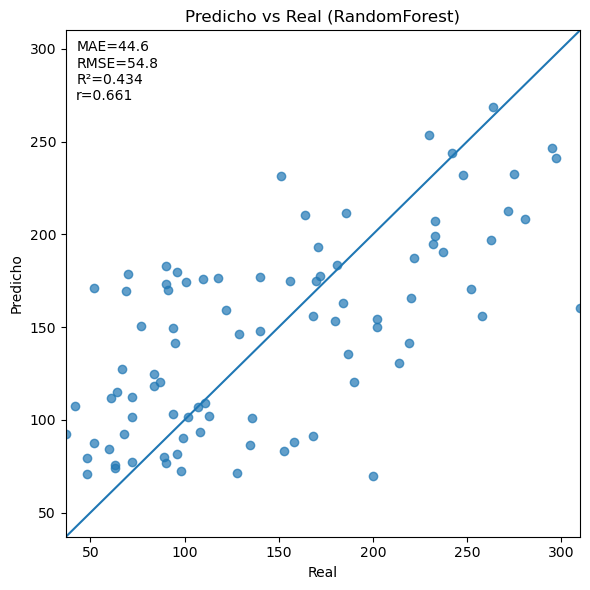

— Interpretación —
• Ajuste global: R²=0.434, correlación r=0.661. Menor dispersión alrededor de la diagonal ⇒ mejor.
• Sesgo medio: tendencia a SOBREestimar (+0.7).
• Errores en extremos: bajos(≤p20)=-47.1; altos(≥p80)=46.8.
  (Patrón típico de regresión a la media: subestima altos y sobreestima bajos.)
• MAE=44.6 y RMSE=54.8 están en unidades del target (puntos). RMSE>MAE ⇒ hay errores grandes.



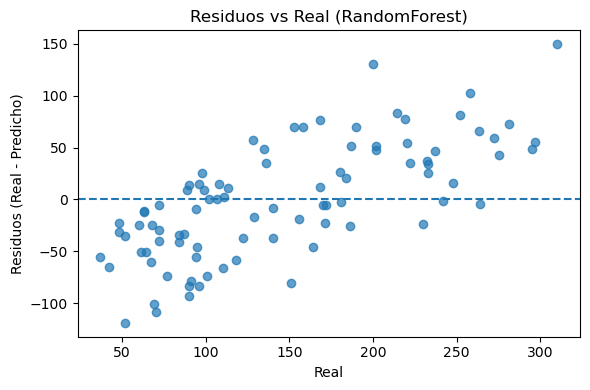

— Interpretación —
• Centrados en 0 y sin patrón ⇒ bien. Curva/U ⇒ sesgo. Dispersión creciente ⇒ heterocedasticidad.
• Media de residuos: -0.68 | Desviación: 55.06



In [101]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(
    n_estimators=300,
    max_depth=None,
    random_state=RANDOM_STATE,
    n_jobs=-1
)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
res_rf = evaluar(y_test, y_pred_rf, etiqueta="RandomForestRegressor")

parity_plot_con_interpretacion(y_test, y_pred_rf, "Predicho vs Real (RandomForest)")
residuos_con_interpretacion(y_test, y_pred_rf, "Residuos vs Real (RandomForest)")

[RandomForestRegressor] N=89 
 MAE, en promedio el modelo se equivoca: 44.578 del target 
 RMSE (cuanto se equivoca el modelo): 54.757 
 R²(correlación entre lo real y lo predicho): 0.434


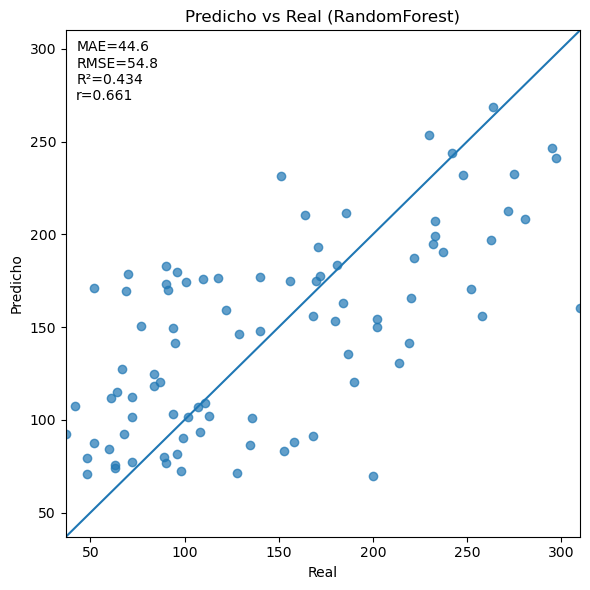

— Interpretación —
• Ajuste global: R²=0.434, correlación r=0.661. Menor dispersión alrededor de la diagonal ⇒ mejor.
• Sesgo medio: tendencia a SOBREestimar (+0.7).
• Errores en extremos: bajos(≤p20)=-47.1; altos(≥p80)=46.8.
  (Patrón típico de regresión a la media: subestima altos y sobreestima bajos.)
• MAE=44.6 y RMSE=54.8 están en unidades del target (puntos). RMSE>MAE ⇒ hay errores grandes.



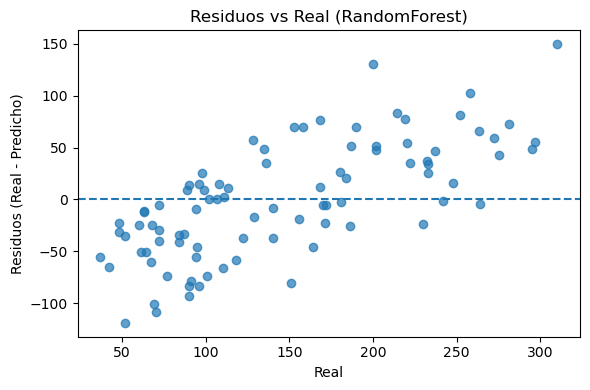

— Interpretación —
• Centrados en 0 y sin patrón ⇒ bien. Curva/U ⇒ sesgo. Dispersión creciente ⇒ heterocedasticidad.
• Media de residuos: -0.68 | Desviación: 55.06



In [102]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(
    n_estimators=300,
    max_depth=None,
    random_state=RANDOM_STATE,
    n_jobs=-1
)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
res_rf = evaluar(y_test, y_pred_rf, etiqueta="RandomForestRegressor")

parity_plot_con_interpretacion(y_test, y_pred_rf, "Predicho vs Real (RandomForest)")
residuos_con_interpretacion(y_test, y_pred_rf, "Residuos vs Real (RandomForest)")


In [103]:
cv = KFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
scores_lr = cross_val_score(linreg, X, y, cv=cv, scoring="r2", n_jobs=-1)
scores_rf = cross_val_score(rf, X, y, cv=cv, scoring="r2", n_jobs=-1)

print(f"CV R² LinearRegression: media={scores_lr.mean():.3f} ± {scores_lr.std():.3f}")
print(f"CV R² RandomForest    : media={scores_rf.mean():.3f} ± {scores_rf.std():.3f}")


CV R² LinearRegression: media=0.478 ± 0.085
CV R² RandomForest    : media=0.427 ± 0.095


In [104]:
tabla = pd.DataFrame([res_lr, res_rf], index=["LinearRegression","RandomForest"])
display(tabla)

def conclusion(tabla):
    mejor = tabla["R2"].idxmax()
    peor  = tabla["R2"].idxmin()
    diff_r2  = tabla.loc[mejor,"R2"] - tabla.loc[peor,"R2"]
    diff_mae = tabla.loc[peor,"MAE"] - tabla.loc[mejor,"MAE"]
    print("\n— Conclusión —")
    print(f"• Según R², el mejor modelo es: {mejor} ")
    print(f"• En error medio, mejora de MAE ≈ {diff_mae:.1f} puntos (positivo = mejor).")
conclusion(tabla)


,N,MAE,RMSE,R2
LinearRegression,89,42.794095,53.853446,0.452603
RandomForest,89,44.578352,54.757109,0.434078



— Conclusión —
• Según R², el mejor modelo es: LinearRegression 
• En error medio, mejora de MAE ≈ 1.8 puntos (positivo = mejor).
